# XGBoost

A very popular implementation of gradient boosting that may be applied to supervised learning problems. XGBoost may be applied to classification or regression problems. 

*Some considerations*:

- Features can be numeric or categorical
- Numeric features should be scaled (e.g., Z-scored)
- Categorical features must be encoded (i.e., one-hot)

**Why is XGBoost so Popular?**

- Speed and performance: Parallelizable able to harness multi-cores and GPUs
- Consistently outperforms all other single-algorithm methods for supervised learning

**When should XGBoost be used**

- With large numbers of training samples (>1000 observations and less than 100 features), or in general when the number of observations is greater than the number of features
- XGBoost is **not** good for image recognition or computer vision

## Building an XGBoost DMatrix

XGBoost gets some of it's processing efficiency from a specialized data object "DMatrix". Data must be typed as a `DMatrix` object in order to pass it to a native API `xgb.train()` method or likewise.

XGBoost also has the ability to deal with categorical variables internally, rather than requiring the user to cast each as one-hot encoded values. But, these input categorical features need to be type `category` in Pandas.

In [3]:
import numpy as np
import seaborn as sns

# Example feature and target arrays
diamonds = sns.load_dataset("diamonds")
X, y = diamonds.drop('price', axis=1), diamonds[['price']]

#Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()
cats

['cut', 'color', 'clarity']

In [7]:
for col in cats: 
    X[col] = X[col].astype('category')
X.dtypes #See category types

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
x           float64
y           float64
z           float64
dtype: object

`DMatrix` objects are built as the following:

In [8]:
from sklearn.model_selection import train_test_split

#Train/Test split
X, y = diamonds.drop('price', axis=1), diamonds[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1973)

#Build DMatrix
dtrain_reg__diamonds = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg__diamonds = xgb.DMatrix(X_test, y_test, enable_categorical=True)

## Boosting & Base Learners

_Boosting_ is not a specific machine learning algorithm but rather a concept that can be applied to a set of ML algorithms (i.e., a "meta-algorithm"). It is an ensemble meta-model (of which XGBoost is an example) that is used to convert many _weak learners_ into a strong learner. The resulting combination of learners allows _non-linear_ modeling of spaces that linear models may struggle to understand.

- _Weak Learner_: An ML algorithm that is slightly better than chance (e.g., a binary decision tree whose predictions are slightly better than 50%)

- _Boosting_: Iteratively builds a set of weak models on subsets of the data. Then, weights are applied to each weak learner based on its performance on unseen data. The boosting meta-algorithm aggregates those weighted predictions to obtain a prediction that is much stronger than the individual predictions.

### Decision Trees

Generally, the base learner of the XGBoost ensemble algorithm. Decision trees make a categorical choice given some data. They are composed of a series of binary decisions that ultimately yield a prediction at the tree's leaves. They are constructed iteratively, one split at a time based on an information criterea that is superior to all other splits. They are built until they run out of information or more-commonly until a stopping criterea is met (to reduce model variance).

The resulting boosted mode is the weighted sum of decision trees. Notice that this leads to a non-linear combination of non-linear base-learners. This is an advantage of decision trees over linear boosters.

### CARTs

XGBoost uses a special type of decision tree called a _CART: Classification and Regression Tree_. In this tree, rather than leaves containing a boolean prediction, each leaf contains a real-valued score regardless of whether it will be used for classification or regression. A threshold is then used if classification is required.

An example using the SciKit-learn API:

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Data
housing_df = pd.read_csv('datasets/ames_housing_trimmed_processed.csv') 
X, y = housing_df.loc[:, housing_df.columns != 'SalePrice'], housing_df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1973)

#Model 
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror'
    , booster='gbtree'
    , n_estimators=100
    , seed=1973)
xg_reg.fit(X_train, y_train)

#Results
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 40829.939634


### Linear Base Learners

Linear base learners are a sum of linear coefficients. A resulting XGBoost'd model is a weighted sum of linear models, which is linear itself. Note that this ultimatel linearity may be a disadvantage for this booster type, and a reason that it is rarely used.

Linear base learners are only available in the XGBoost learning API (i.e., not SKLearn) with the `"gblinear"` booster param (as opposed to the default `"gbtree"`).

The following is an example using the XGBoost learning API:

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Data
housing_df = pd.read_csv('datasets/ames_housing_trimmed_processed.csv') 
X, y = housing_df.loc[:, housing_df.columns != 'SalePrice'], housing_df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1973)
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)

#Model
params={
    "booster":"gblinear"
    , "objective":"reg:squarederror"
}
xgb_reg = xgb.train(params
                   , dtrain=DM_train
                   , num_boost_round=100)

#Results
preds = xg_reg.predict(DM_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 36026.123322


## Objective Functions & Metrics

Objective functions are A.K.A. _loss functions_. These functions quantify how far off a prediction is from the actual result. That is, they measure the difference between estimated and true values for a given collection of data. The goal in training an ML model is too _minimize_ this loss function across data passed through the model, especially unseen data at training time. The smaller this loss, the more _performant_ the model is said to be.

The loss function is specified in a dictionary as the `'objective'` as follows:

```python
params = {"objective": "reg:squarederror", "tree_method": 'gpu_hist', ...}
```

Metrics are used _after_ training to evaluate overall performance (e.g., accuracy, recall, precision).

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

X, y = diamonds.drop("cut", axis=1), diamonds[['cut']]

## Regression with XGBoost

Regression machine learning problems predict real values rather than classes. Common performance metrics used in the regression context are Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). RMSE is diproportionately sensitive to large differences, while MAE lacks some nice mathematical properties that make it less used as a performance metric (like what?).

The regression objective function commonly used is `reg:squarederror`

## Cross-Validation in XGBoost

Using a single test-set (i.e., the _validation set_) to validate the results of a machine learning model is problematic, as the model is able to implicitly memorize the test-set in its iterative optimization steps. This is because the hyperparameter optimization will optimize to the specific validation test-set, which may not generalize as well to new test-sets or future observations.

Cross-validation generates many non-overlapping train/test splits. Then the _average_ test-set performance is reported across all splits.
The following is an example of cross validation in XGBoost

In [19]:
import xgboost as xgb
import pandas as pd

housing_df = pd.read_csv('datasets/ames_housing_trimmed_processed.csv') 
housing_dmat = xgb.DMatrix(data=housing_df.loc[:, housing_df.columns != 'SalePrice'], label=housing_df.SalePrice)
params={"objective":"reg:squarederror", "max_depth":4} #Defines the type of XGB model & hyperparams 
cv_results = xgb.cv(
	dtrain=housing_dmat\
    , params=params\
    , nfold=4\
	, num_boost_round=1000\
	, metrics="error"
	, as_pandas=True
)

#Results
print("RMSE: %f" %((cv_results['test-error-mean']).iloc[-1]))

RMSE: -180920.195890


## Visualization in XGBoost

XGBoost provides several ways to visualize the results of a trained model. Some common visualization techniques include:

- Feature Importance Plot
- Partial Dependence Plot
- Tree Visualization

Let's explore each of these visualization techniques in detail.

### Tree Visualization

Builds a tree graph for an arbitrary `num_trees` numbered booster. Visualizes the boolean splits and ultimate leaf values.

Error: <stdin>: syntax error in line 1 near 'bias'


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tpng']' returned non-zero exit status 1. [stderr: b"Error: <stdin>: syntax error in line 1 near 'bias'\n"]

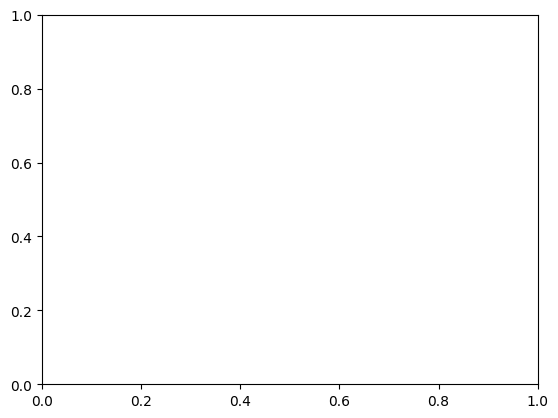

In [ ]:
import matplotlib.pyplot as plt

# xgb.plot_tree(xg_reg, num_trees=0)
# plt.show()

### Feature Importance Plot

To visualize the feature importance of a trained model, we can use the `plot_importance` function from the XGBoost library. This function generates a bar plot showing the "importance" of each feature in the model, defined by the number of splits on that feature across _all_ the models boosters.

Here is an example code snippet to plot the feature importance:

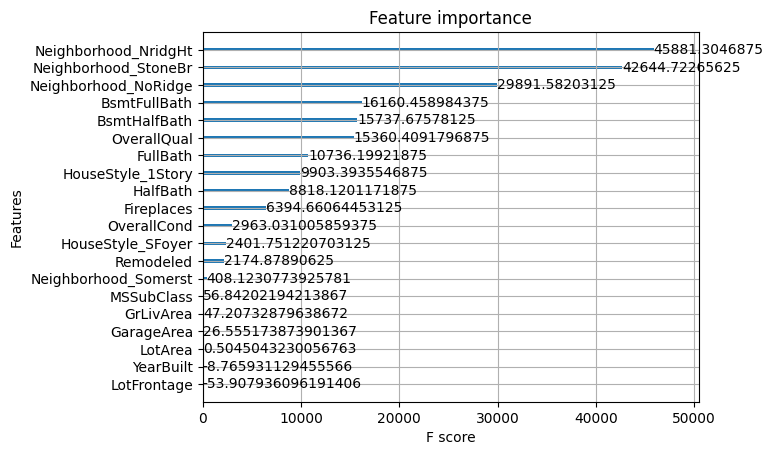

In [4]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot the feature importance
xgb.plot_importance(xg_reg, max_num_features=20)
plt.show()

## Tuning XGBoost Models

Tuning can make a large difference in the final performance of an XGBoost model. 

### Early Stopping

Each XGBoost model will eventually reach a number of boosters that continue to improve performace in the loss function on the _training_ data, it will no longer improve performance on _unseen_ data and will likely get worse as the model _overfits_. We can observe this by passing a test dataset to the `xgb.train()` method.

In [13]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

#Data
X, y = diamonds.drop('price', axis=1), diamonds[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1973)
dtrain_reg__diamonds = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg__diamonds = xgb.DMatrix(X_test, y_test, enable_categorical=True)

#Training
params = {"objective": "reg:squarederror", "tree_method": 'hist'}#"gpu_hist"}
evals = [(dtrain_reg__diamonds, "train"), (dtest_reg__diamonds, "validation")]
overfit_model = xgb.train(
    params=params
    , dtrain=dtrain_reg__diamonds
    , num_boost_round=1000
    , evals=evals
    , verbose_eval=50
)

[0]	train-rmse:3977.45382	validation-rmse:3964.19581
[50]	train-rmse:431.70047	validation-rmse:538.63653
[100]	train-rmse:373.46210	validation-rmse:539.33940
[150]	train-rmse:333.44188	validation-rmse:543.16646
[200]	train-rmse:304.72793	validation-rmse:545.27565
[250]	train-rmse:278.31803	validation-rmse:546.80537
[300]	train-rmse:257.14099	validation-rmse:548.34649
[350]	train-rmse:241.38712	validation-rmse:549.05270
[400]	train-rmse:225.49989	validation-rmse:550.64497
[450]	train-rmse:212.57000	validation-rmse:551.67702
[500]	train-rmse:200.58807	validation-rmse:552.49024
[550]	train-rmse:190.61486	validation-rmse:553.39085
[600]	train-rmse:181.56090	validation-rmse:554.08512
[650]	train-rmse:173.26425	validation-rmse:554.71815
[700]	train-rmse:164.94672	validation-rmse:555.84915
[750]	train-rmse:157.68441	validation-rmse:556.79311
[800]	train-rmse:150.94229	validation-rmse:556.90705
[850]	train-rmse:144.24425	validation-rmse:557.55886
[900]	train-rmse:138.16588	validation-rmse:557.

XGBoost can tune the `num_boost_round` hyperparameter by testings each addition of a booster against a hold-out set of data and halting the addition of boosters if a given performance metric(s) does not improve on the hold-out set in `early_stopping_rounds` boosts. Got it? Check it:

In [14]:
early_stop_model = xgb.train(
    params=params
    , dtrain=dtrain_reg__diamonds
    , num_boost_round=10000
    , evals=evals
    , verbose_eval=50
    , early_stopping_rounds=10
)

[0]	train-rmse:3977.45382	validation-rmse:3964.19581
[50]	train-rmse:431.70047	validation-rmse:538.63653
[60]	train-rmse:421.17886	validation-rmse:538.36693


The XGBoost model stopped itself at an early round as the performance in the validation set plateaued.

### Regularization with XGBoost

Regularization techniques generally are methods that penalize model objective functions for added complexity of the model in pursuit of avoiding overfitting to the training data. 

In XGBoost, regularization parameters are as follows:

- `gamma`: The minimum loss requirement for a split to occur (alias `min_split_loss`)
- `alpha`: L1 regularization on _leaf_ weights (not linear coefficients), with higher values leading to greater regularization. 
- `lambda`: L2 regularization on _leaf_ weights (not linear coefficients)

As with L1 vs. L2 regularization in linear regression coefficients, `alpha` will tend to eliminate weakly predictive splits entirely, compared to `lambda` which will tend to fade those splits instead.

In [6]:
# L1 Regularization Example

##Imports
import xgboost as xgb
import pandas as pd

##Data 
housing_df = pd.read_csv('datasets/ames_housing_trimmed_processed.csv') 
housing_dmat = xgb.DMatrix(data=housing_df.loc[:, housing_df.columns != 'SalePrice'], label=housing_df.SalePrice)

##Model
params = {"objective":"reg:squarederror", "max_depth":4}
l1_params = [1, 90, 100, 110, 1000]
rmses_l1=[]
for reg in l1_params:
    params["alpha"] = reg
    cv_results = xgb.cv(
        dtrain=housing_dmat
        , params=params
        , nfold=4
        , num_boost_round=100
        # , verbose_eval=10
        , metrics='rmse'
        , as_pandas=True
        , seed=1973
    )
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])
    
#Results
print("Best RMSE as a function of L1")
print(pd.DataFrame(list(zip(l1_params, rmses_l1)), columns=["L1", "RMSE"]))

Best RMSE as a function of L1
     L1          RMSE
0     1  32756.336230
1    90  32176.532759
2   100  32234.275085
3   110  32172.657802
4  1000  32383.730016


### Further XGBoost Hyper Parameters

- `learning_rate`/`eta`: The rate at which each additional booster learns the errors from the prior boosters. It applies a shrinkage factor to each boosters results and helps prevent overfitting. Default set at `0.3`
- `max_depth`: Max number of parent-to-child levels in each tree booster. Default set at `6`
- `subsample`: Percent of samples used per tree. High values will overfit while low values may underfit too.
- `colsample_bytree`: Percent of features used per tree. AKA _bagging_. Can be thought of as additional regularization. Too high a proportion of columns sampled leads to overfitting. 

In the linear model the only tunable parameters are `lambda`, `alpha`, and `lambda_bias`, which is an L2 regularization term on the bias (wild!). And, of course, the number of boosting rounds is itself a tunable hyper parameter. 

# Grid Search & Random Search in XGBoost

_Grid search_ searches exhaustively over a given finite set of hyperparameters. A number of models, equal to the number of distinct sets of hyperparameters, are evaluated according to a given performance metric (e.g., RMSE, log-loss). A best-model is then selected based on that performance metric. An example with XGBoost and Sci-kit Learn:

In [8]:
#Imports
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV

#Data
housing_df = pd.read_csv('datasets/ames_housing_trimmed_processed.csv') 
X, y = housing_df[housing_df.columns.tolist()[:-1]], housing_df[housing_df.columns.tolist()[-1]]

#Model
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9]
                    , 'n_estimators': [200]
                    , 'subsample': [0.3, 0.5, 0.9]}
gbm = xgb.XGBRegressor()

#Grid Search
grid_mse = GridSearchCV(estimator=gbm
                        , param_grid=gbm_param_grid
                        , scoring='neg_mean_squared_error'
                        , cv=4
                        , verbose=1
                       )
grid_mse.fit(X, y)

#Results
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5}
Lowest RMSE found:  29105.179169382693


The drawback to grid search is that the length of search grows quickly with additional hyperparameters, and it is dependent on the user to select performant hyperparameter values along a real-number scale. An alternative to `GridSearch` is Sci-Kit Learn's `RandomizedSearchCV()`. This method of testing hyperparameter performance utilizes a random variable to search for hyperparameter values along a range of _real-numbered_ values. Although random search takes more time than grid search, it is superior for real-valued hyperparameters for which the optimal range is not well understood.

In [9]:
# ... Continuing with data from above ...
from sklearn.model_selection import RandomizedSearchCV

#model
gbm_param_grid__random = {'learning_rate': np.arange(0.01, 1.01, 0.01)
                            , 'n_estimators': np.arange(50, 500, 50)
                            , 'subsample': np.arange(0.05, 1.05, 0.05)}
randomized_mse = RandomizedSearchCV(
    estimator=gbm
    , param_distributions=gbm_param_grid__random
    , n_iter=25
    , scoring='neg_mean_squared_error'
    , cv=4
    , verbose=1
)
randomized_mse.fit(X, y)
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.45, 'n_estimators': 350, 'learning_rate': 0.09}
Lowest RMSE found:  28907.58581418998


Random search does not necessarily simplify the search-time problem and may exacerbate it with increasing number of interations (`n_iter`). However, with enough time and iterations random search is able to lccate performant real-valued hyperparameters.

# Using XGBoost in Pipelines

`Pipeline()` is a SciKit Learn object that takes a list of named 2-tuples (i.e., `('name', StepObject())`). These tuples may be any scikit-learn compatible transformer, or estimator object (must be the final object), specifically objects that implement the `.fit()()`/`.predict()` methods. Then the `Pipeline()` object itself may be used as an "estimator" in the SciKit Learn grid/randomized search or cross validation methods.

In [3]:
#Libraries
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier #? That's not XGBoost...
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import xgboost as xgb

#Data
housing_df = pd.read_csv('datasets/ames_unprocessed_data.csv') 
X, y = housing_df[housing_df.columns.tolist()[:-1]], housing_df[housing_df.columns.tolist()[-1]]
X.LotFrontage = X.LotFrontage.fillna(0) #Some missing data

#Model Pipeline
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=1973)
steps = [("ohe_onestep", DictVectorizer(sparse=False)) #Vectorizes non-numeric data only
          , ('st_scalar', StandardScaler())
          , ('xgb_reg', xgb_reg)]
xgb_pipeline = Pipeline(steps)

#Results
scores = cross_val_score(
    xgb_pipeline
    , X.to_dict("records") #Required for DictVectorizer
    , y
    , scoring='neg_mean_squared_error' #PS - an API-safe convention: make scores negative?
    , cv=10
)
avg_rmse = np.mean(np.sqrt(np.abs(scores)))
print('Final RMSE:', avg_rmse)

Final RMSE: 28295.21900720611


# Acknowledgements

These notes were created for studying an XGBoost tutorial from Datacamp, as well as an additional course from Datacamp.


- Using XGBoost in Python Tutorial: https://www.datacamp.com/tutorial/xgboost-in-python
Extreme Gradient Boosting with XGBoost: https://app.datacamp.com/learn/courses/extreme-gradient-boosting-with-xgboost 